### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between demanded magnetic field between current configuration

In [ ]:
!pip install -U "ray[data,train,tune,serve]"

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

Good to go


In [2]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
load_file_num = 1460
train_file_num = 1000
grid_size = 21
data = ReadCurrentAndField (foldername,filepattern, load_file_num)


data=data.reshape(load_file_num,grid_size,grid_size,grid_size,18)
mask = torch.cat((torch.ones(1,1,1,1,12),1e3*torch.ones(1,1,1,1,6)), dim=4)
# position unit mm, B field unit mT, Current unit Ampere
data = mask*data

sparsity = 4

Position_Bfield =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,12:].reshape(-1,6) 
Current = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:12].reshape(-1,12) 

print(np.abs(Position_Bfield[:,3:]).mean())
print(data.shape)
print('position Bfield shape', Position_Bfield.shape)
print('Current shape', Current.shape)


tensor(12.8117)
torch.Size([1460, 21, 21, 21, 18])
position Bfield shape torch.Size([216000, 6])
Current shape torch.Size([216000, 12])


In [19]:
print(os.getcwd())

/root/Qubot_Elastica/Modeling eMNS


In [22]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop_v2 import train_ANN
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer, TorchConfig
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray, os
import torch.nn.functional as F

# construct dataset

Position_Bfield =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,12:].reshape(-1,6) 

Current = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:12].reshape(-1,12)

dataset = eMNS_Dataset(
    x=Position_Bfield,
    y=Current
)

# split the dataset to train, validation, test
train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

# normailzation
extremes = dataset.train_norm_ANN(train_indices = train_set.indices, boundary_index=3)

###############################################
# Config the neural network
###############################################
num_input = 6
num_output = 12
fc_stages = [(num_input,128,1),(128,64,1),(64,32,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)

loss_func = lambda current, Bfield, position, forward_model: F.mse_loss(current, torch.zeros_like(current)) + F.l1_loss(Bfield, forward_model(torch.cat((current, position), axis =1)))
# forward_model_path = r"./Trained_model/EMS_ANN_v2.pt"
# forward_model = torch.load(model_path)['model']
# forward_model.eval()

################################################
# Train the neural network
################################################

train_loop_config = {
                'epochs': 50,
                'lr_max': 1e-4,
                'lr_min': 2.5e-7,
                'batch_size': 128,
                'L2_norm'   : 0,
                'verbose': False,
                'schedule': [],
                'learning_rate_decay': 0.5,
                'num_input'   : num_input,
                'num_output'  : num_output,
                'fc_stages'   : fc_stages,
                'backward'    : True,
                'maxB'        : extremes[2],
                'minB'        : extremes[3],
                'maxC'        : extremes[4],
                'minC'        : extremes[5],
                'device'      : device,
                'loss_func'   : loss_func,
                'forward_model_path': os.path.abspath("./Trained_model/EMS_ANN_v2.pt")
                # You can even grid search various datasets in Tune.
                # "datasets": tune.grid_search(
                #         [ds1, ds2]
                #     ),
}

scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = use_gpu,
    resources_per_worker={"CPU":7, "GPU":1}
)

run_config = RunConfig(name="EMS_ANN_backward_v2",checkpoint_config=CheckpointConfig(num_to_keep=1))

def train_loop_per_worker(params):
    train_ANN(train_set=train_set, valid_set=valid_set, config=params)

# for windows
# torch_config = TorchConfig(backend="nccl")
trainer = TorchTrainer(
    train_loop_per_worker = train_loop_per_worker,
    train_loop_config = train_loop_config,
    scaling_config = scaling_config,
    run_config = run_config,
    # torch_config= torch_config # for windows

)
result = trainer.fit()



(TorchTrainer pid=12552) Started distributed worker processes: 
(TorchTrainer pid=12552) - (ip=192.168.122.3, pid=12591) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=12591) Setting up process group for: env:// [rank=0, world_size=1]


(RayTrainWorker pid=12591) Epoch 0, Iteration 1519, loss = 0.0773
(RayTrainWorker pid=12591) Got rmse 2.977475643157959
(RayTrainWorker pid=12591) Got rmse 2.97784161567688
(RayTrainWorker pid=12591) 


(RayTrainWorker pid=12591) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/EMS_ANN_backward_v2/TorchTrainer_2221e_00000_0_2024-04-19_03-30-13/checkpoint_000000)


(RayTrainWorker pid=12591) Epoch 1, Iteration 3038, loss = 0.0876
(RayTrainWorker pid=12591) Got rmse 2.4518778324127197
(RayTrainWorker pid=12591) Got rmse 2.457702159881592
(RayTrainWorker pid=12591) 
(RayTrainWorker pid=12591) Epoch 2, Iteration 4557, loss = 0.0809
(RayTrainWorker pid=12591) Got rmse 2.226017713546753
(RayTrainWorker pid=12591) Got rmse 2.232442617416382
(RayTrainWorker pid=12591) 
(RayTrainWorker pid=12591) Epoch 3, Iteration 6076, loss = 0.0799
(RayTrainWorker pid=12591) Got rmse 2.18505859375
(RayTrainWorker pid=12591) Got rmse 2.191995859146118
(RayTrainWorker pid=12591) 
(RayTrainWorker pid=12591) Epoch 4, Iteration 7595, loss = 0.0761
(RayTrainWorker pid=12591) Got rmse 2.1160218715667725
(RayTrainWorker pid=12591) Got rmse 2.121037483215332
(RayTrainWorker pid=12591) 
(RayTrainWorker pid=12591) Epoch 5, Iteration 9114, loss = 0.0708
(RayTrainWorker pid=12591) Got rmse 2.0871901512145996
(RayTrainWorker pid=12591) Got rmse 2.091614246368408
(RayTrainWorker pid

(RayTrainWorker pid=12591) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/EMS_ANN_backward_v2/TorchTrainer_2221e_00000_0_2024-04-19_03-30-13/checkpoint_000001)
2024-04-19 03:53:21,563	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).


(RayTrainWorker pid=12591) Got rmse 2.075857400894165
(RayTrainWorker pid=12591) 


2024-04-19 03:53:22,697	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-19 03:53:22,705	INFO tune.py:1021 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/EMS_ANN_backward_v2' in 0.0521s.
2024-04-19 03:53:22,720	INFO tune.py:1053 -- Total run time: 1389.11 seconds (1388.99 seconds for the tuning loop).


In [ ]:
from torchsummary import summary
summary(fc_network, (1,6))
for param_tensor in fc_network.state_dict():
    print(param_tensor, '\t', fc_network.state_dict()[param_tensor].size())

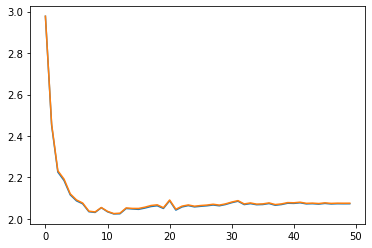

In [23]:
from utils import plot_ray_results
plot_ray_results(results=result, metrics_names = ['rmse_val','rmse_train'])

In [24]:
checkpoint_data = torch.load(os.path.join(result.checkpoint.path,"model.pt"))

model_path = r"./Trained_model/EMS_ANN_backward_v2.pt"
torch.save(checkpoint_data, model_path)

## Test dataset performance

In [63]:
extremes

(tensor(50.),
 tensor(-50.),
 tensor(63.7902),
 tensor(-65.4425),
 tensor(14.9997),
 tensor(-14.9944))

In [25]:
# position unit mm, current unit Ampere, B field unit mT
sparsity = 1
# Position_Bfield_test =data[train_file_num:, ::sparsity, ::sparsity, ::sparsity, :6].reshape(-1,6) 

# Current_test = data[train_file_num:, ::sparsity, ::sparsity, ::sparsity,:12].reshape(-1,12)

Position_Bfield_test =data[:train_file_num, ::sparsity, ::sparsity, ::sparsity, 12:].reshape(-1,6) 

Current_test = data[:train_file_num, ::sparsity, ::sparsity, ::sparsity,:12].reshape(-1,12)

num_sample = Position_Bfield_test.shape[0]
print('position Bfield shape', Position_Bfield_test.shape)
print('Current shape', Current_test.shape)

# construct dataset
test_set = eMNS_Dataset(
    x=Position_Bfield_test.clone(),
    y=Current_test
)
print(test_set.x.abs().mean())
print(Position_Bfield_test.abs().mean())
test_set.test_norm_ANN(extremes=extremes, boundary_index=3)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=train_loop_config['batch_size'],
    shuffle=False)

print(test_set.x.abs().mean())
print(Position_Bfield_test.abs().mean())

position Bfield shape torch.Size([9261000, 6])
Current shape torch.Size([9261000, 12])
tensor(19.3242)
tensor(19.3242)
tensor(0.3585)
tensor(19.3242)


In [27]:
from utils import predict_check_rmse_ANN, check_rmse_ANN
from Training_loop_v2 import construct_model_ANN 

model_path = r"./Trained_model/EMS_ANN_backward_v2.pt"
backward_model = torch.load(model_path)['model']

prediction, rmse, mse, Rsquare = predict_check_rmse_ANN(test_loader, backward_model, config=train_loop_config)
# check_rmse_ANN(test_loader, backward_model, config=train_loop_config)

 current rmse: 7.640779495239258, L2 before: 909.8939819335938, L2 after backward model: 145.4042510986328
Got rmse 2.184913158416748, num_samples 9261000


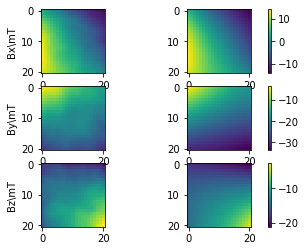

In [28]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
grid_test = int(np.ceil(grid_size/sparsity))
B_est = prediction.reshape(-1, grid_test, grid_test, grid_test, 3)

Bfield_test = Position_Bfield_test[:,3:].reshape(-1, grid_test, grid_test, grid_test, 3)
# Bfield_test = data[train_file_num:,:,:,:,15:]

current_index=50
z_plane_index= 4
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    B_est_sample = B_est[current_index,:,:,z_plane_index,i-1]
    B_desired_sample = Bfield_test[current_index,:,:,z_plane_index,i-1]
    vmin = min(B_est_sample.min(), B_desired_sample.min())
    vmax = max(B_est_sample.max(), B_desired_sample.max())
    norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    ax = plt.subplot(3,2,2*i-1)
    img = plt.imshow(B_est_sample, norm=norm)    
    plt.ylabel(ylables[i-1])
    ax2 = plt.subplot(3,2,2*i)
    img2 = plt.imshow(B_desired_sample, norm=norm)
    plt.colorbar(img,ax=[ax,ax2])

plt.show()

In [ ]:
import numpy as np 
A = np.arange(21)
print(A[::4])
print(A[::1])

In [ ]:
A = torch.arange(3) + 0.0
B = A.reshape(1,3)
print(F.mse_loss(B, torch.zeros_like(B)))
print(torch.linalg.norm(B))

In [ ]:
np.sqrt(5)